In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

df_train = pd.read_csv('/kaggle/input/titanic/train.csv', index_col='PassengerId')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv', index_col='PassengerId')

# Observe shape
print(f"Train dataset: {df_train.shape}")

# Count NaN values
print("\n--- Train NaN Values ---")
print(df_train.isnull().sum().sort_values(ascending=False))

'''We can see that there are a lot of Cabin NaN values and some more on Age.
- For Cabin, first approach is to drop the feature (there is like a 70% of missing values), or 
a hard transformation (1 = thereIsCabin, 0 = thereIsNoCabin...).
- For Age, we should study the best way to impute the missing values. First approach is to use
the mean value, but since age seems to be an important feature (maybe kids have better chances
to survive), we should improve this. Maybe using the name (Mr, Mrs, Master for kids...)
'''

Train dataset: (891, 11)

--- Train NaN Values ---
Cabin       687
Age         177
Embarked      2
Name          0
Pclass        0
Survived      0
Sex           0
Parch         0
SibSp         0
Fare          0
Ticket        0
dtype: int64


'We can see that there are a lot of Cabin NaN values and some more on Age.\n- For Cabin, first approach is to drop the feature (there is like a 70% of missing values), or \na hard transformation (1 = thereIsCabin, 0 = thereIsNoCabin...).\n- For Age, we should study the best way to impute the missing values. First approach is to use\nthe mean value, but since age seems to be an important feature (maybe kids have better chances\nto survive), we should improve this. Maybe using the name (Mr, Mrs, Master for kids...)\n'

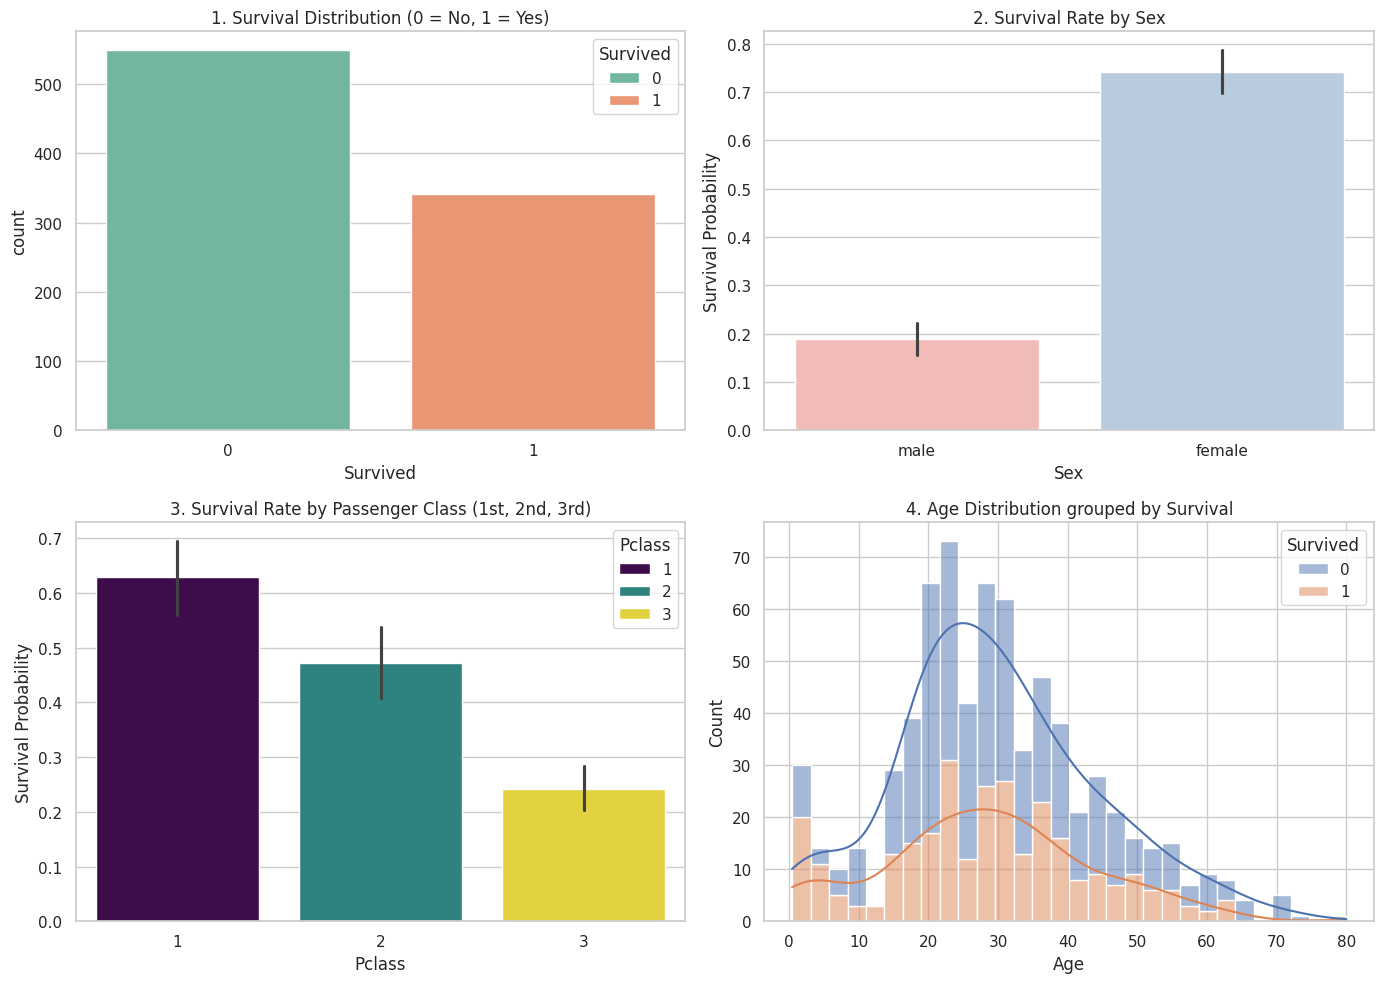

'Best insights from these plots, the target variable is well balanced (not perfect but manag\neable), there is a strong correlation between women and survival rate (~73% of women survived). \nThere is also an observable correlation between classes and survival rates, and the age distribution\nshows us that most of the children survived, but for elder ages there is not a visible correlation.'

In [77]:
sns.set_theme(style="whitegrid")

# Create a large figure with 4 subplots (2 rows by 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Target Variable Distribution
sns.countplot(data=df_train, x='Survived', hue='Survived',palette='Set2', ax=axes[0, 0])
axes[0, 0].set_title('1. Survival Distribution (0 = No, 1 = Yes)')

# 2. The Gender factor
sns.barplot(data=df_train, x='Sex', y='Survived', hue='Sex', palette='Pastel1', ax=axes[0, 1])
axes[0, 1].set_title('2. Survival Rate by Sex')
axes[0, 1].set_ylabel('Survival Probability')

# 3. The Socioeconomic factor
sns.barplot(data=df_train, x='Pclass', y='Survived', hue='Pclass', palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('3. Survival Rate by Passenger Class (1st, 2nd, 3rd)')
axes[1, 0].set_ylabel('Survival Probability')

# 4. The Age factor (Distribution)
sns.histplot(data=df_train, x='Age', hue='Survived', multiple='stack', kde=True, bins=30, ax=axes[1, 1])
axes[1, 1].set_title('4. Age Distribution grouped by Survival')

# Adjust layout to prevent overlapping text
plt.tight_layout()
plt.show()

'''Best insights from these plots, the target variable is well balanced (not perfect but manag
eable), there is a strong correlation between women and survival rate (~73% of women survived). 
There is also an observable correlation between classes and survival rates, and the age distribution
shows us that most of the children survived, but for elder ages there is not a visible correlation.'''

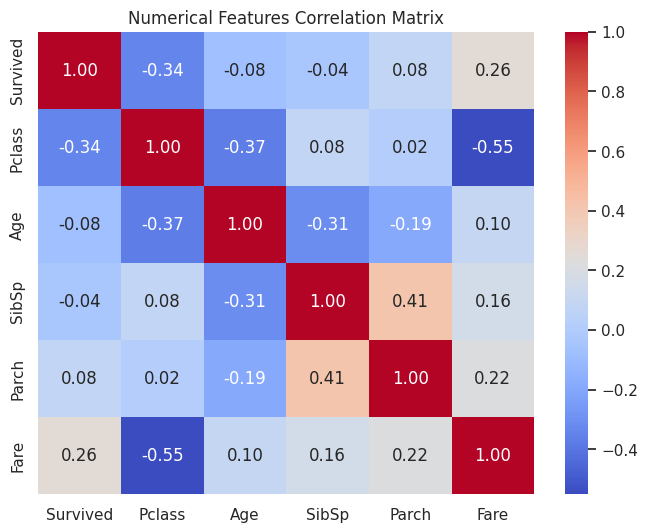

'We can observe some correlations (negative correlation between class and survived, which will\nbe quite useful, and the strongest is between class and fare, which is obvious because \npoorest classes will spend less money)'

In [78]:
# Filter only numerical columns for the correlation matrix to avoid errors
num_cols = df_train.select_dtypes(include=['number'])

plt.figure(figsize=(8, 6))

# Plot the heatmap: annot=True shows the numbers, cmap sets the color scheme
sns.heatmap(num_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Numerical Features Correlation Matrix')

plt.show()

'''We can observe some correlations (negative correlation between class and survived, which will
be quite useful, and the strongest is between class and fare, which is obvious because 
poorest classes will spend less money)'''

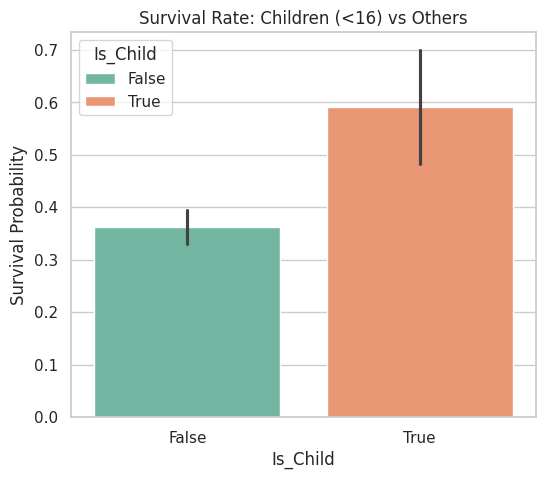

'There is an obvious correlation between children (age < 16) and survival rate'

In [79]:
# Plotting Survival rate for children (<16)
plt.figure(figsize=(6, 5))
sns.set_theme(style="whitegrid")

sns.barplot(
    data=df_train.assign(Is_Child=df_train['Age'] < 16), 
    x='Is_Child', 
    y='Survived', 
    hue='Is_Child',
    palette='Set2'
)

plt.title('Survival Rate: Children (<16) vs Others')
plt.ylabel('Survival Probability')

plt.show()

'''There is an obvious correlation between children (age < 16) and survival rate'''

In [80]:
# I want to extract the name titles and see their mean age
df_train['Title'] = df_train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

mean_ages = df_train.groupby('Title')['Age'].mean().round(1)

print("--- Mean Age by Title ---")
print(mean_ages.sort_values(ascending=False))

--- Mean Age by Title ---
Title
Capt        70.0
Col         58.0
Sir         49.0
Major       48.5
Lady        48.0
Rev         43.2
Dr          42.0
Don         40.0
Jonkheer    38.0
Mrs         35.9
Countess    33.0
Mr          32.4
Ms          28.0
Mme         24.0
Mlle        24.0
Miss        21.8
Master       4.6
Name: Age, dtype: float64


In [81]:
# I want to process ages in order to impute NaN values with the mean of their name title (Master
# for example is for ~4.6 year old children)

from sklearn.preprocessing import FunctionTransformer

def impute_ages(df):
    df_processed = df.copy()
    
    df_processed['Title'] = df_processed['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    
    df_processed['Age'] = df_processed['Age'].fillna(
        df_processed.groupby('Title')['Age'].transform('mean')
    )
    
    return df_processed

age_imputer = FunctionTransformer(impute_ages)

In [82]:
# I want to use the information of the deck feature. It has a letter and a number, I would
# to see if there is any relation with the Class

# 1. Creamos una columna temporal 'Deck' extrayendo la primera letra (o 'N' si es nulo)
df_train['Deck'] = df_train['Cabin'].fillna('N').str[0]

# 2. Creamos una tabla cruzada entre la Cubierta (Deck) y la Clase (Pclass)
deck_class_cross = pd.crosstab(df_train['Deck'], df_train['Pclass'])
print("--- Cantidad de pasajeros por Cubierta y Clase ---")
print(deck_class_cross)

# 3. Y ya que estamos, calculamos la supervivencia media de cada cubierta
print("\n--- Supervivencia por Cubierta ---")
print(df_train.groupby('Deck')['Survived'].mean().round(3).sort_values(ascending=False))

'''We can observe that all passengers with Deck A,B,C are from 1st Class, most of D are from
1st Class, and the majority of NaN deck values are from 3rd Class'''

--- Cantidad de pasajeros por Cubierta y Clase ---
Pclass   1    2    3
Deck                
A       15    0    0
B       47    0    0
C       59    0    0
D       29    4    0
E       25    4    3
F        0    8    5
G        0    0    4
N       40  168  479
T        1    0    0

--- Supervivencia por Cubierta ---
Deck
D    0.758
E    0.750
B    0.745
F    0.615
C    0.593
G    0.500
A    0.467
N    0.300
T    0.000
Name: Survived, dtype: float64


'We can observe that all passengers with Deck A,B,C are from 1st Class, most of D are from\n1st Class, and the majority of NaN deck values are from 3rd Class'

In [83]:
# Function to impute Deck NaN values and process the other ones in order to just use the 
# first letter
def impute_deck(df):
    df_clean = df.copy()
    
    df_clean['Deck'] = df_clean['Cabin'].fillna('N').str[0]
    
    df_clean['Deck'] = df_clean['Deck'].replace('T', 'N')
    
    return df_clean

deck_imputer = FunctionTransformer(impute_deck)

In [84]:
# I want to observe the distribution of survivance rate depending on the family size of the 
# passengers, in order to use the features SibSp and Parch
df_temp = df_train.copy()
df_temp['FamilySize'] = df_temp['SibSp'] + df_temp['Parch'] + 1
df_temp['Is_Alone'] = (df_temp['FamilySize'] == 1).astype(int)

print("--- Survival Rate: Alone vs With Family ---")
alone_stats = df_temp.groupby('Is_Alone')['Survived'].mean().round(3) * 100
alone_stats.index = ['With Family (0)', 'Alone (1)']
print(alone_stats.astype(str) + '%')

print("\n--- Survival Rate by Exact Family Size ---")
family_stats = df_temp.groupby('FamilySize').agg(
    Survival_Rate=('Survived', 'mean'),
    Passenger_Count=('Survived', 'count')
)

family_stats['Survival_Rate'] = (family_stats['Survival_Rate'] * 100).round(1).astype(str) + '%'
print(family_stats)

'''As we can see, we can get quite interesting insights from the family size, and it will be 
always to have less features but useful than more noisy features. It will probably better
to have only family size instead of parch and sibsp (and maybe also a binary variable for
is alone)'''

--- Survival Rate: Alone vs With Family ---
With Family (0)    50.6%
Alone (1)          30.4%
Name: Survived, dtype: object

--- Survival Rate by Exact Family Size ---
           Survival_Rate  Passenger_Count
FamilySize                               
1                  30.4%              537
2                  55.3%              161
3                  57.8%              102
4                  72.4%               29
5                  20.0%               15
6                  13.6%               22
7                  33.3%               12
8                   0.0%                6
11                  0.0%                7


'As we can see, we can get quite interesting insights from the family size, and it will be \nalways to have less features but useful than more noisy features. It will probably better\nto have only family size instead of parch and sibsp (and maybe also a binary variable for\nis alone)'

In [85]:
# Function to calculate familiy size and is_alone
def calculate_family(df):
    df_processed = df.copy()
    
    # Calculate total family size (Siblings/Spouses + Parents/Children + Passenger themselves)
    df_processed['FamilySize'] = df_processed['SibSp'] + df_processed['Parch'] + 1
    
    # Create a binary flag: 1 if the passenger is traveling alone, 0 otherwise
    # .astype(int) converts True/False into 1/0
    df_processed['Is_Alone'] = (df_processed['FamilySize'] == 1).astype(int)
    
    return df_processed

# 2. Convert it into a Pipeline transformer
family_transformer = FunctionTransformer(calculate_family)

In [86]:
# I want to drop useless columns like Ticket (so random and useless), Name (it will overfit
# the model), and PassengerId (since it is just an index)
def drop_useless_columns(df):
    df_clean = df.copy()
    
    cols_to_drop = ['Ticket', 'Name', 'Cabin', 'Parch', 'SibSp']
    
    cols_to_drop = [col for col in cols_to_drop if col in df_clean.columns]
    
    df_clean = df_clean.drop(columns=cols_to_drop)
    
    return df_clean

drop_transformer = FunctionTransformer(drop_useless_columns)

In [87]:
# Now simple imputers and One Hot encoders to fill and preprocess final data (and have numerical
# values)

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numerical_transformer = SimpleImputer(strategy='median')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
])

categorical_cols = ['Sex', 'Embarked', 'Title', 'Deck']
numerical_cols = ['Pclass', 'Age', 'Fare', 'FamilySize', 'Is_Alone']

final_encoder = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [89]:
# Pre-processing pipeline
from sklearn.pipeline import Pipeline

pre_processing = Pipeline(steps=[
    ("age", age_imputer),
    ("deck", deck_imputer),
    ("family", family_transformer),
    ("drop", drop_transformer),
    ("encoder", final_encoder)
])

pre_processing.set_output(transform="pandas") # To have a dataframe instead of an array

Pipeline(steps=[('age',
                 FunctionTransformer(func=<function impute_ages at 0x7fcc246ce200>)),
                ('deck',
                 FunctionTransformer(func=<function impute_deck at 0x7fcc246ce840>)),
                ('family',
                 FunctionTransformer(func=<function calculate_family at 0x7fcc246cf380>)),
                ('drop',
                 FunctionTransformer(func=<function drop_useless_columns at 0x7fcc246cf420>)),
                ('encoder',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Pclass', 'Age', 'Fare',
                                                   'FamilySize', 'Is_Alone']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Embarked', 'Title',
                                                   'Deck'])]))])